This example makes a station plot, complete with sky cover and weather symbols, using a station plot layout built into MetPy. The station plot itself is straightforward, but there is a bit of code to perform the data-wrangling (hopefully that situation will improve in the future). Certainly, if you have existing point data in a format you can work with trivially, the station plot will be simple.

The `StationPlotLayout` class is used to standardize the plotting various parameters (i.e. temperature), keeping track of the location, formatting, and even the units for use in the station plot. This makes it easy (if using standardized names) to re-use a given layout of a station plot.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot, StationPlotLayout, simple_layout
from metpy.units import units

%matplotlib inline

In [2]:
# Utility function for working with the text data we get back in arrays
def make_string_list(arr):
    return [s.decode('ascii') for s in arr]

# The setup

First read in the data. We use `numpy.loadtxt` to read in the data and use a structured `numpy.dtype` to allow different types for the various columns. This allows us to handle the columns with string data.

In [3]:
f = get_test_data('station_data.txt')
all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                      usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                      dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                      ('slp', 'f'), ('air_temperature', 'f'),
                                      ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                      ('weather', '16S'),
                                      ('wind_dir', 'f'), ('wind_speed', 'f')]))

This sample data has *way* too many stations to plot all of them. Instead, we just select a few from around the U.S. and pull those out of the data file.

In [4]:
# Get the full list of stations in the data
all_stids = make_string_list(all_data['stid'])

# Pull out these specific stations
whitelist = ['OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
             'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
             'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
             'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
             'SAT', 'BUY', '0CO', 'ZPC', 'VIH']

# Loop over all the whitelisted sites, grab the first data, and concatenate them
data_arr = np.concatenate([all_data[all_stids.index(site)].reshape(1,) for site in whitelist])

First, look at the names of variables that the layout is expecting:

In [5]:
simple_layout.names()

['cloud_coverage',
 'dew_point_temperature',
 'air_pressure_at_sea_level',
 'eastward_wind',
 'northward_wind',
 'present_weather',
 'air_temperature']

Next grab the simple variables out of the data we have (attaching correct units), and put them into a dictionary that we will hand the plotting function later:

In [6]:
# This is our container for the data
data = dict()

# Copy out to stage everything together. In an ideal world, this would happen on
# the data reading side of things, but we're not there yet.
data['longitude'] = data_arr['lon']
data['latitude'] = data_arr['lat']
data['air_temperature'] = data_arr['air_temperature'] * units.degC
data['dew_point_temperature'] = data_arr['dewpoint'] * units.degC
data['air_pressure_at_sea_level'] = data_arr['slp'] * units('mbar')

Notice that the names (the keys) in the dictionary are the same as those that the layout is expecting.

Now perform a few conversions:
- Get wind components from speed and direction
- Convert cloud fraction values to integer codes [0 - 8]
- Map METAR weather codes to WMO codes for weather symbols

In [7]:
# Get the wind components, converting from m/s to knots as will be appropriate
# for the station plot
u, v = get_wind_components(data_arr['wind_speed'] * units('m/s'),
                           data_arr['wind_dir'] * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
data['cloud_coverage'] = (8 * data_arr['cloud_fraction']).astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
wx_text = make_string_list(data_arr['weather'])
wx_codes = {'':0, 'HZ':5, 'BR':10, '-DZ':51, 'DZ':53, '+DZ':55,
            '-RA':61, 'RA':63, '+RA':65, '-SN':71, 'SN':73, '+SN':75}
data['present_weather'] = [wx_codes[s.split()[0] if ' ' in s else s] for s in wx_text]

All the data wrangling is finished, just need to set up plotting and go:

In [8]:
# Set up the map projection and set up a cartopy feature for state borders
import cartopy.crs as ccrs
import cartopy.feature as feat
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='110m', facecolor='none')

In [9]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering
from matplotlib import rcParams
rcParams['savefig.dpi'] = 255

# The payoff

/Users/jleeman/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


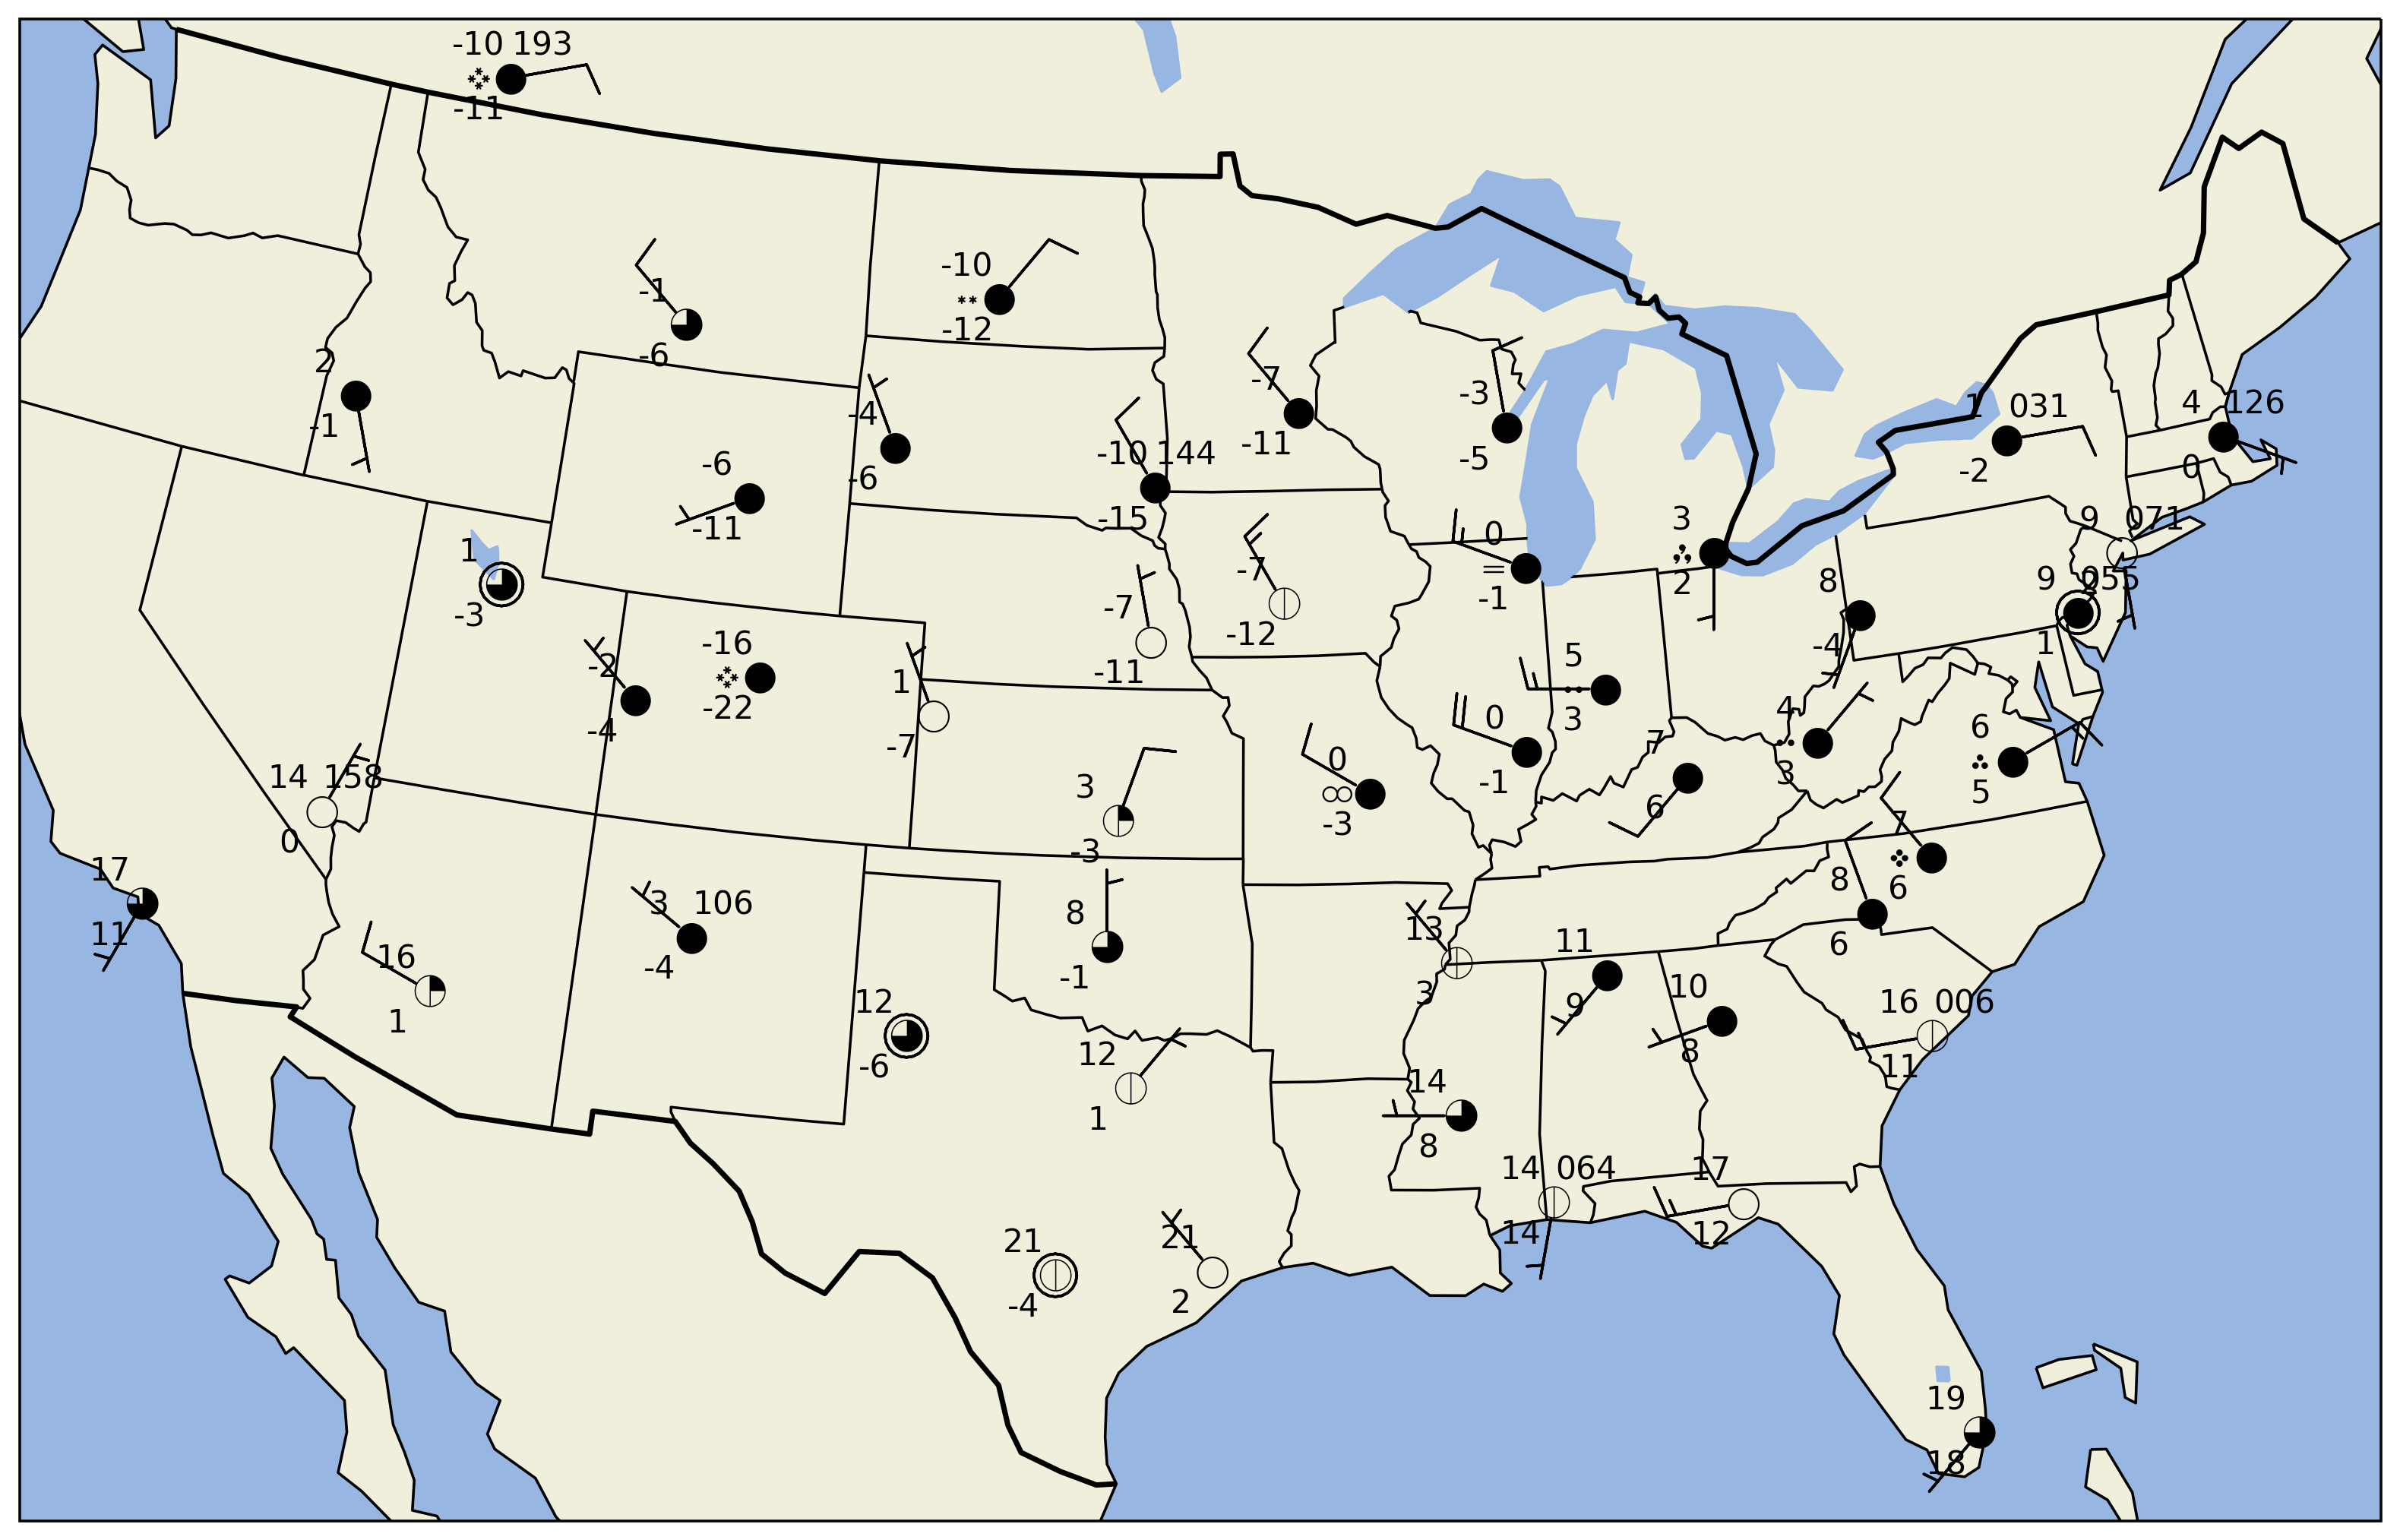

In [10]:
# Create the figure and an axes set to the projection
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
simple_layout.plot(stationplot, data)

or instead, a custom layout can be used:

In [11]:
# Just winds, temps, and dewpoint, with colors. Dewpoint and temp will be plotted
# out to Farenheit tenths. Extra data will be ignored
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degF', color='darkred')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degF',
                        color='darkgreen')

# Also, we'll add a field that we don't have in our dataset. This will be ignored
custom_layout.add_value('E', 'precipitation', fmt='0.2f', units='inch', color='blue')

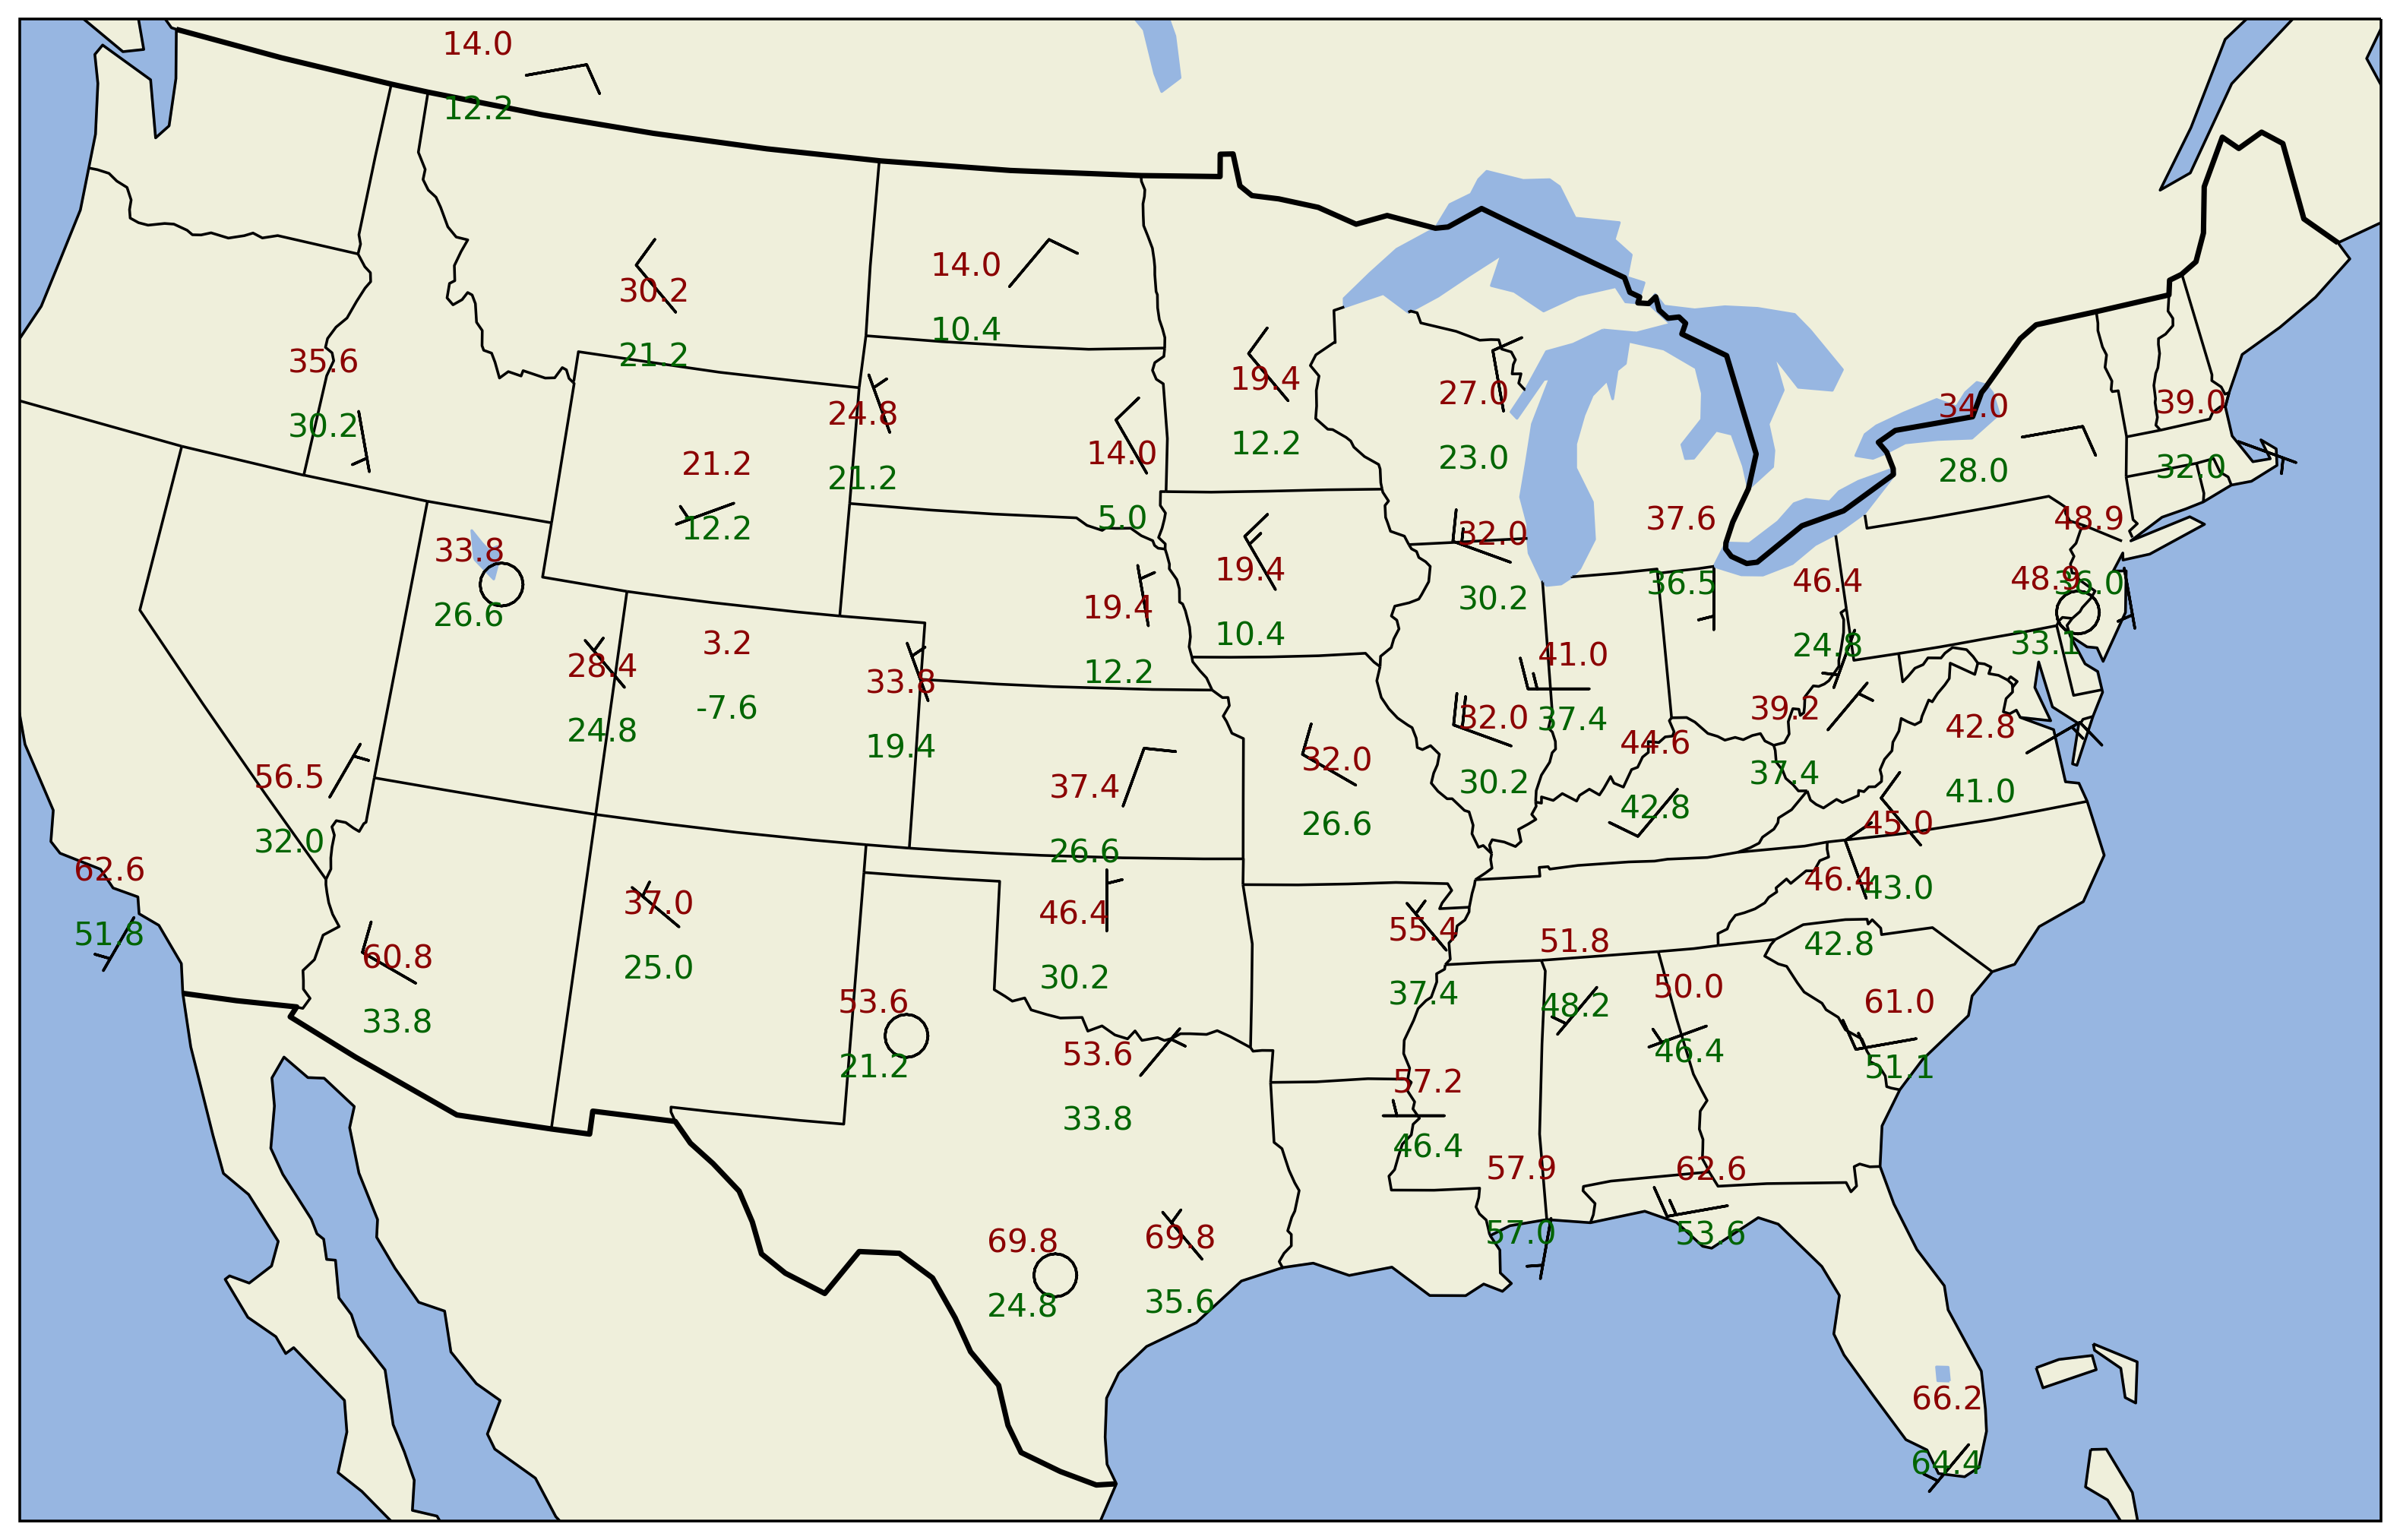

In [12]:
# Create the figure and an axes set to the projection
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)